In [4]:
import pandas as pd
import seaborn as sb
import io
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from sklearn import preprocessing
from itertools import islice
import seaborn as sns
from sklearn.cluster import KMeans
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn import model_selection
import matplotlib
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
import forestci as fci
from sklearn.model_selection import GridSearchCV
import pickle

In [5]:
#!pip install forestci

In [7]:
from google.colab import files
uploaded = files.upload()


Saving test.csv to test.csv


In [16]:
train = pd.read_csv('train.csv', parse_dates=[2],index_col = 'Date')
store = pd.read_csv('store.csv')
train.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-31,2,5,6064,625,1,1,0,1
2015-07-31,3,5,8314,821,1,1,0,1
2015-07-31,4,5,13995,1498,1,1,0,1
2015-07-31,5,5,4822,559,1,1,0,1


In [17]:
train['Year'] = train.index.year
train['Month'] = train.index.month
train['Day'] = train.index.day
train['WeekOfYear'] = train.index.weekofyear
train['Dates']=train.apply(lambda x:'%s-%s-%s' % (x['Year'],x['Month'],x['Day']),axis=1)
train['Dates']=pd.to_datetime(train['Dates'])
train_store = pd.merge(train, store, how = 'inner', on = 'Store')


In [19]:
train_store.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,WeekOfYear,Dates,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,5263,555,1,1,0,1,2015,7,31,31,2015-07-31,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,1,4,5020,546,1,1,0,1,2015,7,30,31,2015-07-30,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
2,1,3,4782,523,1,1,0,1,2015,7,29,31,2015-07-29,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
3,1,2,5011,560,1,1,0,1,2015,7,28,31,2015-07-28,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
4,1,1,6102,612,1,1,0,1,2015,7,27,31,2015-07-27,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN


In [20]:
state_holidays = train_store.query('StateHoliday=="c" or StateHoliday=="a" or StateHoliday=="b"')
holidays = state_holidays['Dates'].to_list()

# current = 0
# for i, row in train_store.iterrows():
#       if row['Dates'] > holidays[current]:
#           days = (row['Dates'] - holidays[current]).days
          
#       elif (row['Dates'] == holidays[current]):
#           days = 0
#           current+=1
#       else:
#           days = (row['Dates'] - holidays[current+1]).days
#       train_store.at[i,'NumDaysAfterHoliday'] = days

def computeDaysAfterHoliday(train_store):
  current = 0
  for i, row in train_store.iterrows():
      #print(holidays[current],row['Dates'])
      if row['Dates'] > holidays[current]:
          days = (row['Dates'] - holidays[current]).days
          #print(days,'hi')
      elif (row['Dates'] == holidays[current]):
          days = 0
          current+=1
      else:
          days = (row['Dates'] - holidays[current+1]).days
      train_store.at[i,'NumDaysAfterHoliday'] = days

In [21]:

def computeDaysBeforeHoliday(train_store):
  current = 0
  holidays = state_holidays['Dates'].to_list()[::-1]
  for i, row in train_store.iloc[::-1].iterrows():
      days = 0
      first_holiday_found=False
      try:
          if row['Dates'] < holidays[current]:
              days = int((holidays[current] - row['Dates']).days)
              
              
          elif (row['Dates'] == holidays[current]):
              days = 0
              current+=1
              first_holiday_found = True
      except:
          days= 50 # assign an average of 50 days to holiday if the dataset stops before the next holiday
      train_store.at[i,'NumDaysToHoliday'] = days*1
def determinePosInMonth(train_store):
  dates = dates = pd.DatetimeIndex(train_store['Dates'].values)
  train_store['PosInMonth'] = [0 if day < 11 else 1 if day < 21 else 2 for day in dates.day]



In [22]:
# Gather some features
def build_features(features, data):
    # remove NaNs
    data.loc[data.Open.isnull(), 'Open'] = 1
    data.fillna(0, inplace=True)
    
    features.extend(['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday'])

    # # Label encode some features
    features.extend(['StoreType', 'Assortment', 'StateHoliday'])
    mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
    data.StoreType.replace(mappings, inplace=True)
    data.Assortment.replace(mappings, inplace=True)
    data.StateHoliday.replace(mappings, inplace=True)

    features.extend(['DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear'])
    
    features.extend(['Weekend','Weekday'])
    data['Weekend'] = [0 if day < 6 else 1 for day in data.DayOfWeek]
    data['Weekday'] = [0 if day > 5 else 1 for day in data.DayOfWeek]
    
    
    features.extend(['NumDaysToHoliday','NumDaysAfterHoliday'])
    computeDaysAfterHoliday(data)
    computeDaysBeforeHoliday(data)
    

    features.append('PosInMonth')
    determinePosInMonth(data)


    # Calculate time competition open time in months
    features.append('CompetitionOpen')
    data['CompetitionOpen'] = 12 * (data.Year - data.CompetitionOpenSinceYear) + \
        (data.Month - data.CompetitionOpenSinceMonth)
    # Promo open time in months
    features.append('PromoOpen')
    data['PromoOpen'] = 12 * (data.Year - data.Promo2SinceYear) + \
        (data.WeekOfYear - data.Promo2SinceWeek) / 4.0
    data['PromoOpen'] = data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    data.loc[data.Promo2SinceYear == 0, 'PromoOpen'] = 0

    # Indicate that sales on that day are in promo interval
    features.append('IsPromoMonth')
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', \
             7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    data['monthStr'] = data.Month.map(month2str)
    data.loc[data.PromoInterval == 0, 'PromoInterval'] = ''
    data['IsPromoMonth'] = 0
    for interval in data.PromoInterval.unique():
        if interval != '':
            for month in interval.split(','):
                data.loc[(data.monthStr == month) & (data.PromoInterval == interval), 'IsPromoMonth'] = 1

    return data

In [23]:
features = []
print("augment features")
build_features(features, train_store)

print(features)

augment features
['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday', 'StoreType', 'Assortment', 'StateHoliday', 'DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear', 'Weekend', 'Weekday', 'NumDaysToHoliday', 'NumDaysAfterHoliday', 'PosInMonth', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']


In [24]:
#print(holidays)
train_store[features]


,Store,CompetitionDistance,Promo,Promo2,SchoolHoliday,StoreType,Assortment,StateHoliday,DayOfWeek,Month,Day,Year,WeekOfYear,Weekend,Weekday,NumDaysToHoliday,NumDaysAfterHoliday,PosInMonth,CompetitionOpen,PromoOpen,IsPromoMonth
0,1,1270.0,1,0,1,3,1,0,5,7,31,2015,31,0,1,50.0,57.0,2,82.0,0.00,0
1,1,1270.0,1,0,1,3,1,0,4,7,30,2015,31,0,1,50.0,56.0,2,82.0,0.00,0
2,1,1270.0,1,0,1,3,1,0,3,7,29,2015,31,0,1,50.0,55.0,2,82.0,0.00,0
3,1,1270.0,1,0,1,3,1,0,2,7,28,2015,31,0,1,50.0,54.0,2,82.0,0.00,0
4,1,1270.0,1,0,1,3,1,0,1,7,27,2015,31,0,1,50.0,53.0,2,82.0,0.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1115,5350.0,0,1,1,4,3,0,6,1,5,2013,1,1,0,83.0,4.0,0,24157.0,6.75,0
1017205,1115,5350.0,0,1,1,4,3,0,5,1,4,2013,1,0,1,84.0,3.0,0,24157.0,6.75,0
1017206,1115,5350.0,0,1,1,4,3,0,4,1,3,2013,1,0,1,85.0,2.0,0,24157.0,6.75,0
1017207,1115,5350.0,0,1,1,4,3,0,3,1,2,2013,1,0,1,86.0,1.0,0,24157.0,6.75,0


In [25]:
num_columns = ['CompetitionDistance', 'NumDaysToHoliday',
                   'NumDaysAfterHoliday', 'CompetitionOpen']
for num_feature in num_columns:
  min_max_scaler = MinMaxScaler()
  train_store[num_feature] = min_max_scaler.fit_transform(train_store[num_feature].values.reshape(-1,1))
  # trains_store[num_feature] = min_max_scaler.transform(train_store[num_feature].values.reshape(-1,1))

In [26]:
train_store.head(10)
print(features,'hi')
x_features = train_store[features]
target = train_store["Sales"]
X_train, X_test, y_train, y_test = model_selection.train_test_split(x_features, target, test_size = 0.20)
pipe = Pipeline([("classifier", RandomForestRegressor())])
# Create dictionary with candidate learning algorithms and their hyperparameters
grid_param = [
                
                {"classifier": [LinearRegression()],
                 "classifier__n_jobs": [1,2,None],
                 
                 },
                {"classifier": [RandomForestRegressor()],
                 "classifier__n_estimators": [10],
                 "classifier__min_samples_leaf":[1,2],
                 "classifier__max_leaf_nodes": [2,10]}]
# create a gridsearch of the pipeline, the fit the best model
gridsearch = GridSearchCV(pipe, grid_param, cv=5, verbose=0,n_jobs=-1,scoring ='r2') # Fit grid search
best_model = gridsearch.fit(X_train,y_train)

['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday', 'StoreType', 'Assortment', 'StateHoliday', 'DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear', 'Weekend', 'Weekday', 'NumDaysToHoliday', 'NumDaysAfterHoliday', 'PosInMonth', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth'] hi


In [27]:
print(best_model.best_estimator_)

print("The mean accuracy of the model is:",best_model.score(X_test,y_test))

Pipeline(steps=[('classifier',
                 RandomForestRegressor(max_leaf_nodes=10, min_samples_leaf=2,
                                       n_estimators=10))])
The mean accuracy of the model is: 0.5505539027783598


In [28]:
best_model.fit(X_train, y_train)
y_hat = best_model.predict(X_test)



In [62]:
#calculating loss function
from sklearn.metrics import mean_absolute_error

# error calculation
def rmse(y, yhat):
    rmse = np.sqrt(mean_absolute_error(y, yhat))
    return rmse

err = rmse(y_test, y_hat)
err

41.406211134372946

RMSE - Root Mean Square Error Loss is our chosen loss function. 

RMSE is a good measure of how accurately the model predicts the response, and it is the most **important** criterion for fit if the main purpose of the model is prediction.


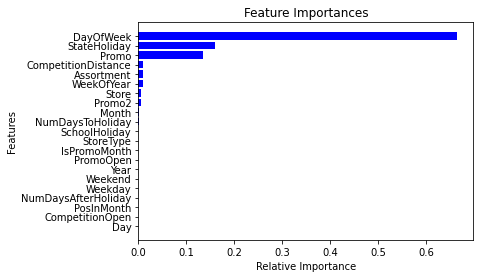

In [61]:
# get the feature importance  
importances = best_model.best_estimator_.named_steps["classifier"].feature_importances_
indices = np.argsort(importances)
featuresRanked = []
for f in range(X_train.shape[1]):
    featuresRanked.append(X_train.columns[indices[f]])
plt.title('Feature Importances')
plt.barh(range(X_train.shape[1]), importances[indices], color='b', align='center')
plt.yticks(range(X_train.shape[1]), featuresRanked)
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()



It can be seen that the most important features for our model are:

**DayOfWeek**: The particular day of the week (Monday - Sunday)

**StateHoliday**: If there is a state holiday or not

**Promo**: Is there a promo going on or not? 

In [29]:
test = pd.read_csv('test.csv',  parse_dates=[3],index_col = 'Date')
test['Year'] = test.index.year
test['Month'] = test.index.month
test['Day'] = test.index.day
test['WeekOfYear'] = test.index.weekofyear
test['Dates']=test.apply(lambda x:'%s-%s-%s' % (x['Year'],x['Month'],x['Day']),axis=1)
test['Dates']=pd.to_datetime(test['Dates'])
test_store = pd.merge(test, store, how = 'inner', on = 'Store')



In [30]:
test_features = []
build_features(test_features,test_store)
print(test_features)

['Store', 'CompetitionDistance', 'Promo', 'Promo2', 'SchoolHoliday', 'StoreType', 'Assortment', 'StateHoliday', 'DayOfWeek', 'Month', 'Day', 'Year', 'WeekOfYear', 'Weekend', 'Weekday', 'NumDaysToHoliday', 'NumDaysAfterHoliday', 'PosInMonth', 'CompetitionOpen', 'PromoOpen', 'IsPromoMonth']


In [ ]:
# current = 0
# holidays = state_holidays['Dates'].to_list()[::-1]
# for i, row in test_store.iloc[::-1].iterrows():
#       #days = 50
#       first_holiday_found=False
#       try:
#           if row['Dates'] < holidays[current]:
#               days = int((holidays[current] - row['Dates']).days)
              
              
#           elif (row['Dates'] == holidays[current]):
#               days = 0
#               current+=1
#               first_holiday_found = True
#       except:
#           days= 50 # assign an average of 50 days to holiday if the dataset stops before the next holiday
#       test_store.at[i,'NumDaysToHoliday'] = days*1

In [59]:
test_store.shape

(41088, 29)

In [32]:
test_store = test_store.set_index('Dates')


In [ ]:
pickle.dump((test_store),open('test_store.pkl','wb'))
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  

# get the folder id where you want to save your file
file = drive.CreateFile()
file.SetContentFile('test_store.pkl')
file.Upload()

<Figure size 864x1368 with 0 Axes>

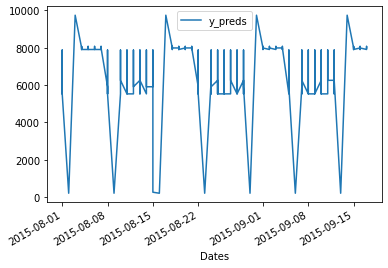

In [33]:
X = test_store[test_store.Store == 1]


X = test_store[test_features]
y_preds = best_model.predict(X)

cars = {'y_preds': y_preds,
        'Dates': X.index.values
        }

df = pd.DataFrame(cars, columns = [ 'y_preds','Dates'])
# furniture = furniture.set_index('Order Date')
plt.figure(figsize=(12,19))
#df = df.set_index('Dates')

df.plot(kind='line',x='Dates',y='y_preds')

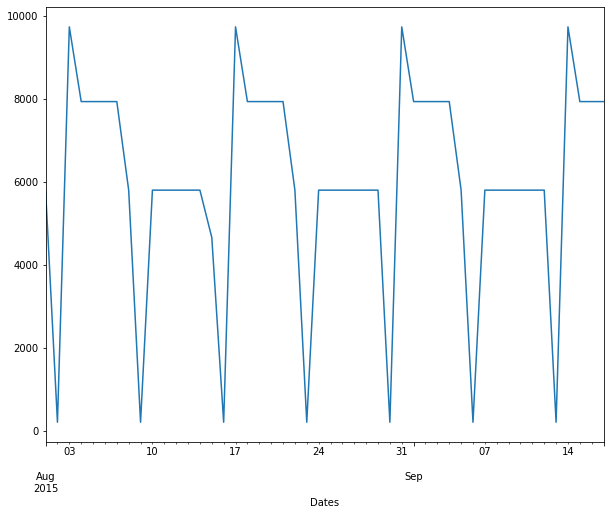

In [34]:
X2 = test_store[test_features]
y_preds2 = best_model.predict(X2)

cars = {'y_preds': y_preds2,
        'Dates': X2.index.values
        }

df = pd.DataFrame(cars, columns = [ 'y_preds','Dates'])
# furniture = furniture.set_index('Order Date')
plt.figure(figsize=(10,8))
df = df.set_index('Dates')

df.groupby('Dates')['y_preds'].mean().plot()

In [ ]:
pickle.dump((best_model),open('model1.pkl','wb'))
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)  

# get the folder id where you want to save your file
file = drive.CreateFile()
file.SetContentFile('model1.pkl')
file.Upload() 